In [1]:
""" Based on https://ceur-ws.org/Vol-3290/short_paper5571.pdf """
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found


/home/musashishi/Documents/football-beauty/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import cv2 # images
import matplotlib.pyplot as plt

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Extract 1 person images

### Test section

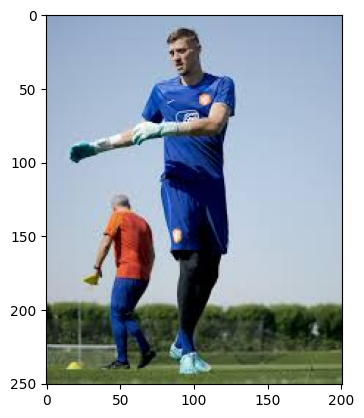

In [28]:
# Test showing image
image_ = cv2.imread("data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert1.jpg")
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

plt.imshow(image_)
plt.show()

In [29]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image_)

[02/08 17:36:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [30]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0, 34], device='cuda:0')
Boxes(tensor([[ 28.6785, 121.2577,  75.4079, 241.3766],
        [ 26.6533,   9.9111, 128.3151, 244.3974],
        [ 16.7857,  63.7713, 126.5705,  97.8452]], device='cuda:0'))


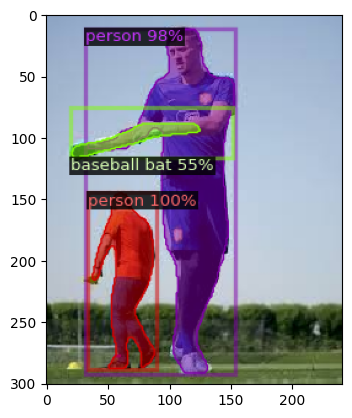

In [31]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image_[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(image_)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [33]:
# Use deterctron2's model_zoo to find images with only 1 person in them (single test person), class 0 is person
outputs["instances"].pred_classes.tolist().count(0)

2

In [34]:
def getImagePaths(path):
    """ Returns a list of all image paths in a directory """
    import os
    image_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [42]:
paths_ = getImagePaths("data/Images/Group A/Netherland Players/Images_Andries Noppert")
paths_

['data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert50.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert40.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert49.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert45.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert44.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert24.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert19.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert8.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert2.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert28.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert38.jpg',
 'data/Images/Group A/Netherland P

In [43]:
def getSinglePersonImages(paths):
    """ Returns a list of images with only 1 person in them """
    single_person_images = []
    for path in paths:
        image_ = cv2.imread(path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        outputs = predictor(image_)
        if outputs["instances"].pred_classes.tolist().count(0) == 1:
            single_person_images.append(path)
    return single_person_images

In [52]:
images_singles_ = getSinglePersonImages(paths_)
print("Number of Andries Noppert's single-person images", len(images_singles_))
print("Percentage of Andries Noppert's single-person images", len(images_singles_)/len(paths_))

Number of Andries Noppert's single-person images 23
Percentage of Andries Noppert's single-person images 0.46


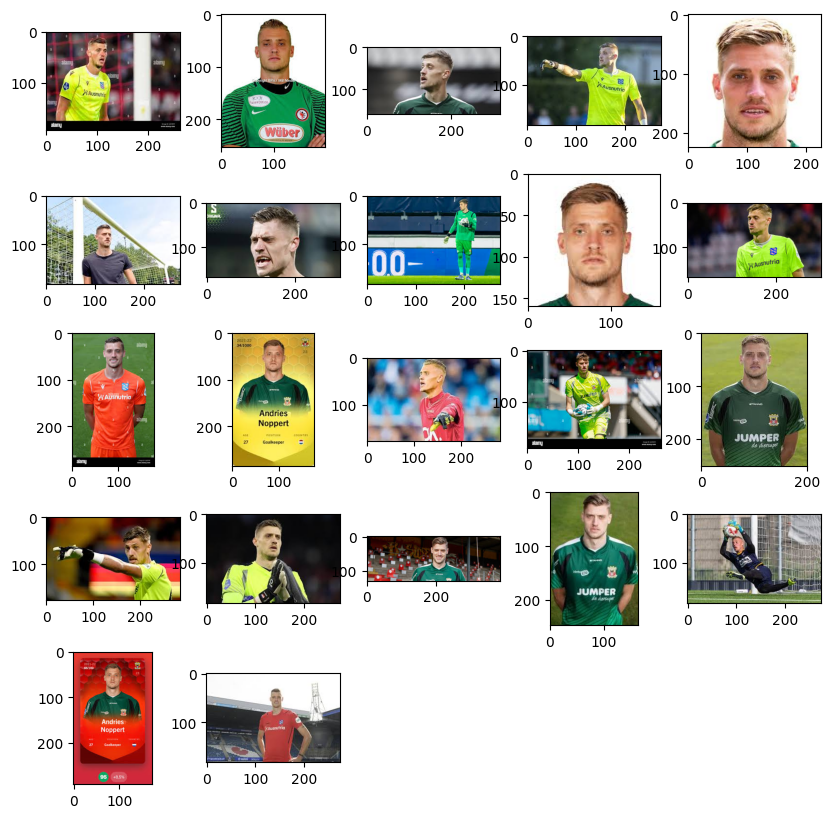

In [51]:
# Display single person images in a grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, len(images_singles_)):
    img = mpimg.imread(images_singles_[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

## Actual

In [6]:
# Do above for all people in the dataset, and save the results in a new folder

In [7]:
# Do a density plot of images with 1 person and percent of the image they take up

In [8]:
# Test the most common densities to see if they are good

In [9]:
# Use model_zoo again to find the faces' orientations